In [986]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy

In [987]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [988]:
importlib.reload(gr)

<module 'graph' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\graph.py'>

In [4]:
word_vectors = KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

In [1032]:
domain = ['apnea','obesity']
filepath=['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv']
graphpath='C:/Users/faisal/PycharmProjects/linkPrediction/graphs'
datapath='C:/Users/faisal/PycharmProjects/linkPrediction/dataframes'
modelpath='C:/Users/faisal/PycharmProjects/linkPrediction/models'
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
time=[1980,1991,2015,1,1]
df, key_list = ut.load_dataset(filepath, column_split)

In [1033]:
#dynamic train graphs and test graph build and save in disk 
importlib.reload(gr)
gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

1141
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1991.gpickle saved, nodes: 73 edges: 90
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1992.gpickle saved, nodes: 76 edges: 81
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle saved, nodes: 88 edges: 72
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1994.gpickle saved, nodes: 118 edges: 91
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle saved, nodes: 158 edges: 171
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle saved, nodes: 170 edges: 206
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle saved, nodes: 182 edges: 181
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle saved, nodes: 177 edges: 202
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999.gpickle saved, nodes: 199 edges: 185
C:/Users/faisal/PycharmProject

In [1034]:
#load all graphs
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1991.gpickle loaded, nodes: 73 edges: 90
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1992.gpickle loaded, nodes: 76 edges: 81
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle loaded, nodes: 88 edges: 72
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1994.gpickle loaded, nodes: 118 edges: 91
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle loaded, nodes: 158 edges: 171
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle loaded, nodes: 170 edges: 206
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle loaded, nodes: 182 edges: 181
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle loaded, nodes: 177 edges: 202
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999.gpickle loaded, nodes: 199 edges: 185
C:/Users/faisal/PycharmPro

In [1037]:
importlib.reload(fs)
importlib.reload(cl)

train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq=5)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

ts = time[1]
te = time[2]
row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
all_combinations = itertools.chain(*[itertools.combinations(feature_names, i + 1)
                                     for i, _ in enumerate(feature_names)])
feature_list = list(all_combinations)
domain_info =  domain[0]+str(ts)+"-"+str(te)+"-"
models  = []
results = []
con = [20]

for feature in feature_list:
    columns_drop = list(set(feature_names).difference(set(feature)))
    if len(feature)==1:
        model_name = '+'.join(feature)
        model_name = domain_info+model_name
        pruned_data = copy.deepcopy(train_data)
        pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
        X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
        results.append(cl.model_evaluate(model, X_test, y_test, batch_size, model_name))
        model_file_name = os.path.join(modelpath, model_name + ".h5")
        model.save(model_file_name)
        models.append(model_name)
        print(model_file_name)
        

pos in time series: 1289 neg in time series: 5455 pos-neg ratio: 0.23629697525206234 total: 6744
dist_aut_art: 3.4010361772676165 dist_y_weight: 5.561200890119386
X shape: (6744, 24, 1) y shape: (6744,)
2024/2024 [==============================] - 0s 36us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea1991-2015-aut.h5
X shape: (6744, 24, 1) y shape: (6744,)
2024/2024 [==============================] - 0s 30us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea1991-2015-art.h5
X shape: (6744, 24, 1) y shape: (6744,)
2024/2024 [==============================] - 0s 33us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea1991-2015-af1.h5
X shape: (6744, 24, 1) y shape: (6744,)
2024/2024 [==============================] - 0s 45us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea1991-2015-af2.h5
X shape: (6744, 24, 1) y shape: (6744,)
2024/2024 [==============================] - 0s 29us/step
C:/Users/faisal/PycharmProjects/linkPredict

In [1100]:
#result
model_names = []
loss = []
acc = []
auc = []
ff = set(['false positive','true positive'])
for row in results:
    for i,r in row.items():
        if i not in ff:
            #print(i,":",row[i])
            pass
    model_names.append(row['model name'].split('-')[2])
    loss.append(row['test score'])
    acc.append(row['test accuracy'])
    auc.append(row['auc'])
    #print()

In [1042]:
#specific feature set classification
importlib.reload(fs)
importlib.reload(cl)

train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq=5)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

ts = time[1]
te = time[2]
row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
con = [10]
#feature define
feature = feature_names
model_name = '+'.join(feature)
model_name = domain_info+model_name
columns_drop = list(set(feature_names).difference(set(feature)))
pruned_data = copy.deepcopy(train_data)
pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)

#train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
result = cl.model_evaluate(model, X_test, y_test, batch_size, model_name)

#evaluation result
not_show = set(['false positive','true positive'])
for i,r in result.items():
    if i not in not_show:
        print(i,":",result[i])

pos in time series: 1289 neg in time series: 5483 pos-neg ratio: 0.2350902790443188 total: 6772
dist_aut_art: 3.4010361772676165 dist_y_weight: 5.561200890119386
X shape: (6772, 24, 11) y shape: (6772,)
2032/2032 [==============================] - 0s 39us/step
model name : apnea1991-2015-aut+art+af1+af2+coun+close+part+y_weight+type+part_cnt+path3
test score : 0.4620670885082305
test accuracy : 0.8159448814204359
auc : 0.6639224649120741


In [1036]:
#feature inclusion testing
importlib.reload(fs)
importlib.reload(cl)

train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq=10)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1289 neg in time series: 10937 pos-neg ratio: 0.11785681631160282 total: 12226
dist_aut_art: 3.4010361772676165 dist_y_weight: 5.561200890119386


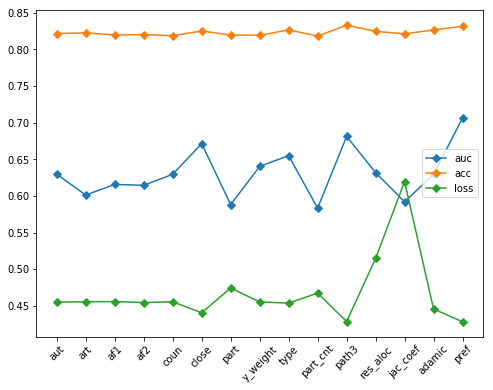

In [1140]:
plt_for = [auc,acc,loss]
plt_for_name = ['auc','acc','loss']
plt.figure(figsize=(8,6))
for i,name in enumerate(plt_for):
    #plt.title(plt_for_name[i])
    plt.xticks(range(len(model_names)), model_names, rotation=45)
    plt.plot(name, '-D',label = plt_for_name[i])
plt.legend(loc='best')
plt.show()